# [AIFFEL_Going Deeper_5] 영화리뷰 텍스트 감성분석하기

## 프로젝트 내용    
네이버 영화리뷰 raw 텍스트 데이터를 전처리하고     
3가지 모델(LSTM, 1-D CNN, GlobalMaxPooling 사용)하여 감성분석 모델 만들기         
이후 학습된 embedding layer를 gensim 패키지를 활용해 분석 후,      
한국어 Word2Vec 모델을 활용해 성능 개선하기    

## 목차
### 1. 네이버 영화리뷰 텍스트 데이터 감성분석 모델 만들기
**- Step 1. 필요한 라이브러리 불러오기**        
**- Step 2. 데이터 준비와 확인**    
**- Step 3. 데이터로더 구성**                
3-1. 데이터의 중복 제거     
3-2. NaN 결측치 제거      
3-3. 한국어 토크나이저로 토큰화      
3-3-1. Part 1_임포트한 라이브러리 공부      
3-3-2. Part 2_토크나이저, 불용어 변수에 담아주기      
3-3-3. Part 3_load_data 함수 정의_중복, 결측치 제거      
3-3-4. Part 4_load_data 함수 정의_X_train, X_test 생성       
3-3-5. Part 5_load_data 함수 정의      
3-3-6. Part 6_load_data 함수 중 wordlist_to_indexlist 함수 정의      
3-4. 시작, 종료 토큰 추가       
3-5. index_to_word 딕셔너리 만들기      
3-6. 인코딩, 디코딩 함수 만들기       
**- Step 4. 모델 구성을 위한 데이터 분석 및 가공**       
4-1. 데이터셋 내 문장 길이 분포, 적절한 최대 문장 길이 지정      
4-2. keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가       
**- Step 5. 모델 구성 및 validation set 구성**       
5-1.  검증용 데이터 분리       
5-2. 3가지 모델 구성      
**- Step 6. 모델 훈련 개시**      
**- Step 7. Loss, Accuracy 그래프 시각화**       
**- Step 8. 학습된 Embedding 레이어 분석**      
**- Step 9. 한국어 Word2Vec 임베딩 활용하여 성능 개선**     
9-1. 학습된 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습      
9-2. 모델 평가       
9-3. 추가로 customized한 model_7 적용      

### 2. 결론(한국어 Word2Vec 적용 전과 후 모델 성능 비교)
### 3. 루브릭 관련 고려한 점
### 4. 추가 공부
### 5. 회고
### 6. References         
         
     

## 글씨 색 표시
### <span style = "color:orange;">- 노랑: 질문! or 짚고가자!</span>    
### <span style = "color:red;">- 빨강: 중요 or 특이사항</span>

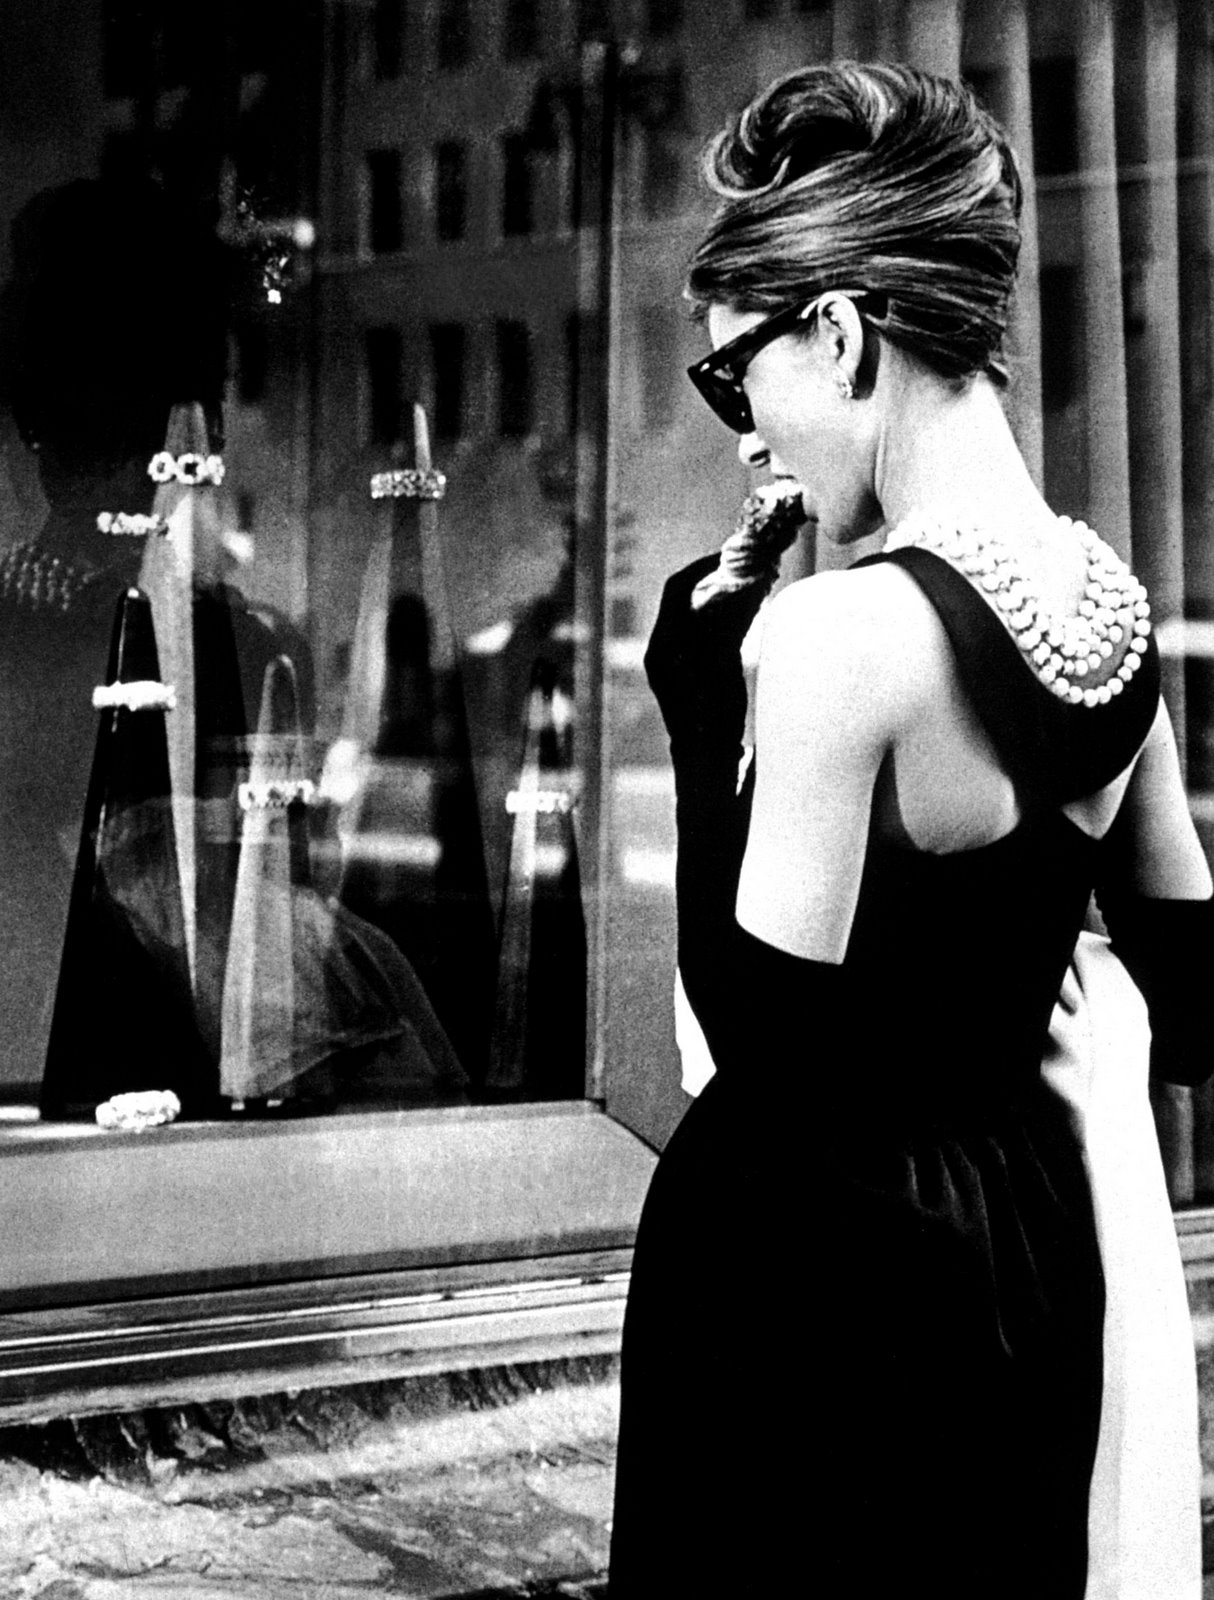

In [2]:
Image("[GD_5_Movie Review] images/breakfast_tiffanys_back.jpg")

# 1. 네이버 영화리뷰 텍스트 데이터 감성분석 모델 만들기

## Step 1. 필요한 라이브러리 불러오기

In [1]:
import pandas
import konlpy
import gensim
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

from konlpy.tag import Mecab
from collections import Counter

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


### <span style = "color:orange;">라이브러리 공부!</span>
  
<span style = "color:red;">import konlpy</span>    
'코엔엘파이'라고 읽는다.     
한국어 정보처리를 위한 파이썬 패키지      
https://konlpy.org/ko/latest/index.html

<span style = "color:red;">import gensim</span>  
Gensim은 주제 모델링, 문서 유사성 분석 및 기타 자연어 처리 (NLP) 작업을 위해 설계된 오픈 소스 파이썬 라이브러리     
Gensim is a Python library for topic modelling(주제 모델링), document indexing and similarity retrieval with large corpora.      
Target audience is the natural language processing (NLP) and information retrieval (IR) community.       
*corpora: corpus의 복수     
https://pypi.org/project/gensim/



from konlpy.tag import Mecab
from collections import Counter

In [2]:
!pip install IPython  
from IPython.display import Image

## Step 2. 데이터 준비와 확인

In [130]:
# 데이터 불러오기(train, test 나누어)
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [49]:
# train_data 확인
train_data.head(20)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [50]:
# test_data 확인
test_data.tail(10)

,id,document,label
49990,9757200,제발 국뽕김치영화좀 그만 만들어라...,0
49991,9653062,재밌는데....?평점이왜?,1
49992,1077821,내일 토요일밤 MBC에서 영화 해준다.... 봐야지... 기대,1
49993,5494272,액션영화로 기대하지말고 스릴러영화라 생각하고 보면 괜찮은 영화인듯^^,1
49994,5567676,정말 너무 재밌음 ㅋ,1
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0
49999,6070594,마무리는 또 왜이래,0


In [6]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(train_data), len(test_data)))

훈련 샘플 개수: 150000, 테스트 개수: 50000


In [7]:
# train_data의 전체 구조 파악
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


#### <span style = "color:red;">전체 150,000개의 데이터인데 document에 149,995개라고 나온다.</span>
5개는 결측치일까?

In [8]:
# test_data의 전체 구조 파악
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


#### <span style = "color:red;">test_data도 50,000개의 데이터 중 document는 49,997개이다.</span>
3개는 결측치일까?

## Step 3. 데이터로더 구성

(출처_노드)     
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면      
숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공한다.      

그러나 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있다.      
이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것부터 시작한다. 

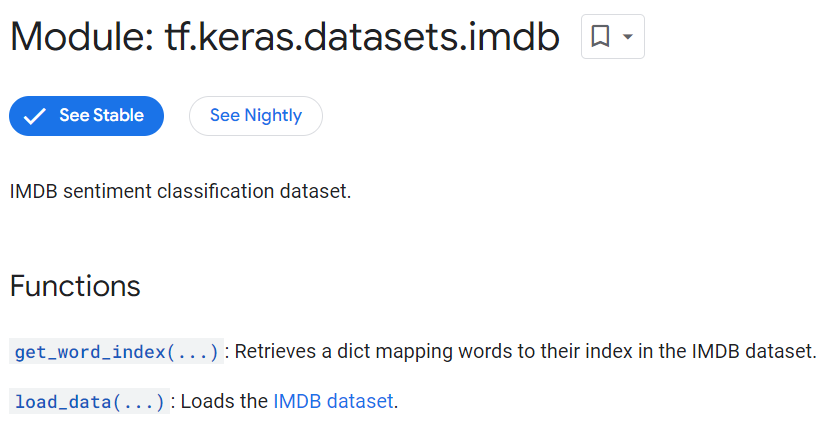

In [9]:
Image("[GD_5_Movie Review] images/01.PNG")

#### <span style = "color:red;">노드의 실습에서 했던 imdb의 데이터의 경우 이렇게 데이터셋이 모듈화? 되어있어 get_word_index()가 있다.</span>
https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb

그래서 노드 실습에서는    
텍스트 데이터가 아니라 이미 숫자로 encode된 텍스트 데이터를 다운로드했다고 하였다.    
word_to_index = imdb.get_word_index()    
이렇게 함으로써 word_to_index()를 바로 만들 수 있었던 것    
  
이미 인코딩이 되어있다는 뜻?      
-> 그렇지 그렇지, 그리고 word:index의 형태로 딕셔너리로 아예 만들어져 있고(get_word_index()에 담겨있는 듯)    


### <span style = "color:orange;">여전히 imdb.data_loader()는 찾을 수가 없는데.. 궁금하다 이게 따로 함수가 있나?</span>
그냥 만든거? 정의해준건가?     

imdb.data_loader()만 출력해보았을 때    

AttributeError: module 'keras.api._v2.keras.datasets.imdb' has no attribute 'data_loader'      
    
이런 에러가 난다.

### <span style = "color:red;">나만의 data_loader()를 만들어보자</span>
data_loader 안에서는 다음을 수행해야 한다고 한다!     

1. 데이터의 중복 제거    
2. NaN 결측치 제거    
3. 한국어 토크나이저로 토큰화    
4. 불용어(Stopwords) 제거    
5. 사전word_to_index 구성    
6. 텍스트 스트링을 사전 인덱스 스트링으로 변환    
7. X_train, y_train, X_test, y_test, word_to_index 리턴 

## Step 3-1. 데이터의 중복 제거

판다스에서 중복을 확인하는 코드는 뭐였죠?     
(예시)     
items_payment = items_payment.drop_duplicates(subset=['상품명']) 

In [18]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [19]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [23]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [30]:
train_data_dupli = train_data.drop_duplicates(subset=['document'])

In [31]:
train_data_dupli

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [32]:
train_data_dupli.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146183 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146183 non-null  int64 
 1   document  146182 non-null  object
 2   label     146183 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


#### <span style = "color:red;">document가 149995 -> 146182로 바뀜</span>

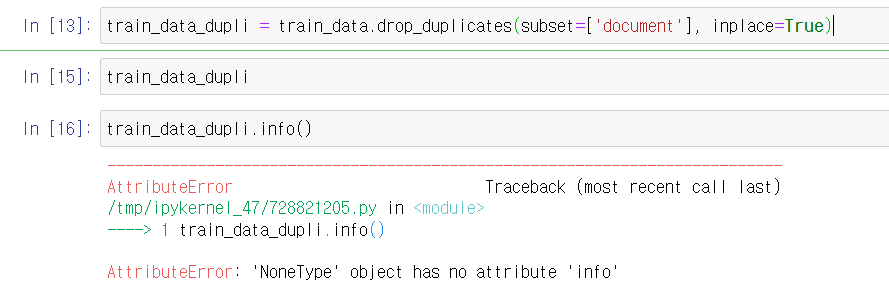

In [17]:
Image("[GD_5_Movie Review] images/10.PNG")

### <span style = "color:orange;">왜 inplace=True를 하면 위 사진처럼 나오지...?</span>

In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [33]:
test_data_dupli = test_data.drop_duplicates(subset=['document'])

In [34]:
test_data_dupli.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49158 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49158 non-null  int64 
 1   document  49157 non-null  object
 2   label     49158 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


#### <span style = "color:red;">document가 아까는 49997이었는데 지금은 49157로 바뀌었다.</span>

**train_data**     
149995 -> 146182     

**test_data**      
49997 -> 49157

## Step 3-2. NaN 결측치 제거

In [35]:
train_data_2 = train_data_dupli.dropna(axis=0)

In [36]:
train_data_dupli.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146183 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146183 non-null  int64 
 1   document  146182 non-null  object
 2   label     146183 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


In [37]:
train_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


#### <span style = "color:red;">전체 데이터수가 146182로 통일되었다.</span>
이번에는 test_data

In [38]:
test_data_2 = test_data_dupli.dropna(axis=0)

In [27]:
test_data_dupli.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49158 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49158 non-null  int64 
 1   document  49157 non-null  object
 2   label     49158 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [28]:
test_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49157 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49157 non-null  int64 
 1   document  49157 non-null  object
 2   label     49157 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


## Okay, 정리 완료!

### <span style = "color:red;">이후 토큰화하는 부분은, 노드의 예시코드 참고</span>
예시 코드 안에 중복, 결측치 제거 내용도 있어 최종 전처리는 노드의 예시코드 내용을 하나씩 공부한 뒤 그 코드로 전처리 진행

## Step 3-3. 한국어 토크나이저로 토큰화

갑자기 한국어 토크나이저로 토큰화한다는게 무슨 뜻인지 와닿지가 않음

### 토큰화란?
문장을 토큰 시퀀스로 나누는 과정      
주어진 코퍼스에서 토큰이라 불리는 단위로 나누는 작업을 토큰화라고 한다      
https://wikidocs.net/21698       

토큰화를 수행하는 프로그램을 토크나이저라고 한다.     

대표적인 한국어 토크나이저로는 은전한닢(mecab), 꼬꼬마(kkma) 등이 있다.       
이들은 언어 전문가들이 토큰화해 놓은 데이터를 학습해 최대한 전문적인 분석 결과와 비슷하게 토큰화를 수행한다.      

(TMI)      
이들 분석기는 토큰화뿐 아니라 품사 부착(Part-Of-Speech Tagging)까지 수행하므로      
토큰화 개념을 넓은 의미로 해석할 때는 토큰화를 토큰 나누기에 품사 부착까지 일컫는 경우도 종종 있다.     
https://ratsgo.github.io/nlpbook/docs/preprocess/tokenization/

### <span style = "color:red;">한국어 토크나이저로 토큰화란</span>
일단 한국어 문장을 한국 토큰 시퀀스로 나누는 과정을 해보자는 말


**토크나이저를 하는 과정은 어떻게 되나요?**

먼저 한국어 토크나이저를 불러와야 하나?

**대표적인 한국어 토크나이저(토큰화를 수행하는 프로그램)는 konlpy**

## <span style = "color:red;">예시 답안 코드 하나씩 톺아보기</span>
#### 먼저 전체 코드

In [ ]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

## Step 3-3-1. Part 1_임포트한 라이브러리 공부 

In [ ]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

### <span style = "color:orange;">첫 번째 부분에서 이렇게 되어있는데 from konlpy.tag import Mecab 이거는 뭘까요?</span>

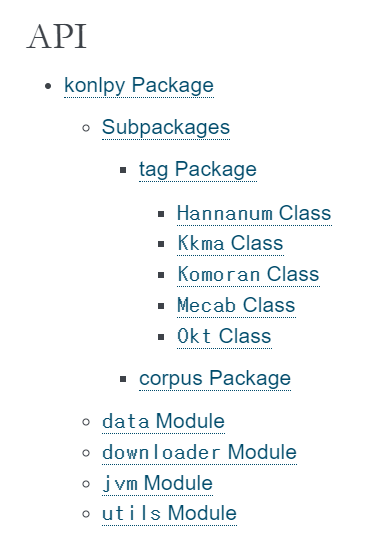

In [29]:
Image("[GD_5_Movie Review] images/08.PNG")

### 이 도식을 보니 도움이 된다.
**konlpy라는 거대한 한국어 정보처리를 위한 파이썬 패키지 안에는**    
tag pakage와 corpus package가 있는데     
tak package 안에는 Hannanum class, Kkma class(Kkma는 꼬꼬마라고 읽는다고 한다.), Komoran class, Mecab class(은전한닢), Okt class가 있는 것 같다.      

토크나이저 okt 같은 경우는 다른 노드에서도 본 것 같다.        
사진 출처_https://konlpy.org/ko/latest/index.html
    
    
### <span style = "color:orange;">그런데 왜 tag package를 사용하는 걸까?</span>
tag는 품사를 알려주는거 아닌가?
품사 부착까지...

### from collections import Counter
그리고 이거는..

collections 모듈의 counter 클래스     
데이터가 몇 번 저장되어있는지를 계산해야 할 때 사전대신 사용하면 매우 유용하다.    

counter 객체는 어떤 데이터가 몇 번 등장했는지를 나타내고 있다.     


counter 클래스의 생성자에 이렇게 중복된 원소가 들어있는 리스트를 인자로 넘기면    
출력값과 같이 각 데이터가 몇 번씩 저장되어있는지를 알려주는 객체를 반환하게 된다.      
https://www.daleseo.com/python-collections-counter/

모듈 안에 클래스가 있나봐     

클래스 ()안 생성자에 인자를 넣어주면     
객체를 반환한다?     


### 예를 들어

In [30]:
from collections import Counter

Counter(["hi", "hey", "hi", "hi", "hi, there", "hello", "hey"])

Counter({'hi': 3, 'hey': 2, 'hi, there': 1, 'hello': 1})

### <span style = "color:orange;">오오오오오 이렇게 나온다!! 그럼 여기에서는 왜 필요한걸까?</span>

## Step 3-3-2. Part 2_토크나이저, 불용어 변수에 담아주기

In [ ]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

### 불용어 정의
무튼 그래서 여기에서 Mecab(은전한닢)이라는 토크나이저를 tokenizer라는 변수에 담아주고     
의, 가, 이 등과 같은 불용어들을 stopwords라는 변수에 담아준다.

그리고 나서 함수를 정의하는데 

## Step 3-3-3. Part 3_load_data 함수 정의_중복, 결측치 제거

In [ ]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

### load_data라는 함수를 정의
num_words는 10000으로 함       
-> 이 말은 단어사전의 크기를 10000으로 한다?    
단어의 개수를 10000개로 한다?     

그리고 중복값과 결측치를 제거함     

**drop_duplicates에서 inplace=True로 주면**    
-> inplace bool, default False    
Whether to modify the DataFrame rather than creating a new one.    

공식문서에 이렇게 쓰여 있는데     
 
기본값 false로 주면 중복값을 뺀 데이터프레임을 하나 더 만든다? 즉 원래의 데이터에 반영이 안된다?    
true로 주면 중복값을 뺀 데이터프레임이 기존의 데이터프레임에 덮어 쓰여진다?     
      
**원본을 변경할지의 여부!    
Pandas 공통사항으로 inplace인수를 사용할 경우 원본에 변경이 적용된다.**

추가로 subset에 입력된 컬럼명을 기준으로 해당 컬럼의 중복값을 검사하게 된다.     
subset이 따로 입력되지 않는 경우는 모든 열에대해 값이 중복인 행을 제거한다.

https://wikidocs.net/154060

### train_data = train_data.dropna(how = 'any') 에서 

**how : {'any' : 존재하면 제거 / 'all' : 모두 결측치면 제거} 제거할 유형이다.** 
포함만 시켜도 제거할지, 전부 NA여야 제거할지 정할 수 있다.    

이 말은 한 행에서 한 컬럼이라도 결측치가 있으면 (행기준) 그 행을 뺄 것인지 의미?     

기본적으로 how 는 'any'이며 이 경우 한 값이라도 NA를 가진다면 해당 레이블을 제거한다.     
how를 'all'로 할 경우 모든값이 NA인 레이블만 삭제된다.      
    
https://wikidocs.net/153202

## Step 3-3-4. Part 4_load_data 함수 정의_X_train, X_test 생성

In [ ]:
X_train = []
for sentence in train_data['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

X_test = []
for sentence in test_data['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

이 부분이 있는데, 

먼저 우리가 받은 train_data와 test_data가 있다.

train_date를 가지고 보면
temp_X = tokenizer.morphs(sentence)를 통해 토큰화를 진행한다고 한다. 

tokenizer.morphs는 곧 Mecab.morphs랑 같은 건가?

### <span style = "color:orange;">특수문자는 토큰화하기 전에 정제(cleaning)안 해주나?</span> 

구두점이나 특수문자를 전부 제거하면 토큰이 의미를 잃어버리는 경우가 발생하기도 한다.      
한국어는 띄어쓰기만으로는 단어 토큰을 구분하기 어렵다. 

토큰화 작업을 단순하게 코퍼스에서 구두점을 제외하고 공백 기준으로 잘라내는 작업이라고 간주할 수는 없다.     
이러한 일은 보다 섬세한 알고리즘이 필요한데 그 이유는    

1. 구두점이나 특수문자를 단순 제외해서는 안된다.
2. 줄임말과 단어 내에 띄어쓰기가 있는 경우가 있다.
라고 한다.

### 형태소 = morpheme
: 뜻을 가진 가장 작은 말의 단위 

형태소에는 두 가지가 있다.

1. 자립 형태소 :      
접사, 어미, 조사와 상관없이 자립하여 사용할 수 있는 형태소. 그 자체로 단어가 된다. 체언(명사, 대명사, 수사), 수식언(관형사, 부사), 감탄사 등이 있다.
2. 의존 형태소 :     
다른 형태소와 결합하여 사용되는 형태소. 접사, 어미, 조사, 어간을 말한다.    
    
그래서 한국어에서 영어에서의 단어 토큰화와 유사한 형태를 얻으려면 어절 토큰화가 아니라 형태소 토큰화를 수행해야 한다.

**코엔엘파이를 통해서 사용할 수 있는 형태소 분석기로**       
Okt(Open Korea Text), 메캅(Mecab), 코모란(Komoran), 한나눔(Hannanum), 꼬꼬마(Kkma)가 있다.

https://wikidocs.net/21698

각각의 메소드는 아래와 같은 기능을 갖고 있습니다.     

1) morphs : 형태소 추출      
2) pos : 품사 태깅(Part-of-speech tagging)      
3) nouns : 명사 추출      
    
    
**morphs(phrase)**     
: Parse phrase to morphemes.      

**nouns(phrase)**      
: Noun extractor.    

**pos(phrase, flatten=True, join=False)**     
: POS tagger.     

그래서      

<span style = "color:red;"> X_train = []     
for sentence in train_data['document']:     
    temp_X = tokenizer.morphs(sentence)      
    temp_X = [word for word in temp_X if not word in stopwords]      
    X_train.append(temp_X)</span>      
 

이 코드는 train_data의 document열에 있는 하나 하나의 데이터들을 sentence라는 변수에 담아 for문을 돌리는데       
Mecab을 담은 변수 tokenizer를 통해 tokenizer.morphs를 함으로써 sentence의 형태소를 추출한다.      
그리고 이것을 temp_X에 담는다.     


그리고 <span style = "color:red;">temp_X = [word for word in temp_X if not word in stopwords]</span> 이 부분은 리스트 내포인데        


for word in temp_X       
위에서 담은 temp_X 안에서 word를 꺼낸다. (형태소로 토크나이저된 형태소들이겠지)      
그 word 들이     
if not word in stopwords 안에서      
word가 stopwords 안에 없다면     
코드 앞부분 'word for word'의 첫 단어 word에 해당이 되어     
temp_X에 담는다는 의미이다.    

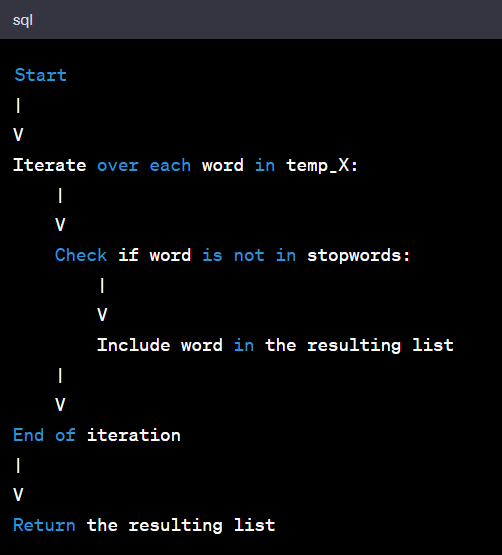

In [3]:
Image("[GD_5_Movie Review] images/18.PNG")

## Step 3-3-5. Part 5_load_data 함수 정의

In [ ]:
words = np.concatenate(X_train).tolist()
counter = Counter(words)
counter = counter.most_common(10000-4)
vocab = ['', '', '', ''] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}

이전 이 코드에서    
X_train = []     
for sentence in train_data['document']:     
    temp_X = tokenizer.morphs(sentence)      
    temp_X = [word for word in temp_X if not word in stopwords]       
    X_train.append(temp_X)         
  
이렇게 담은 X_train 리스트를     

**words = np.concatenate(X_train).tolist()**

이렇게 한다는 건....      
이 안에 담은 단어들의 리스트를 concatenate 합치고 tolist 리스트화 해서 words 변수에 담아준다는 이야기인 것 같다.

### <span style = "color:red;">tolist()에 대해</span>

In [4]:
df = pd.DataFrame({'value':[1,2,3], 'test':['a','b','c']})
df

,value,test
0,1,a
1,2,b
2,3,c


In [5]:
df.values

array([[1, 'a'],
       [2, 'b'],
       [3, 'c']], dtype=object)

In [ ]:
응?

In [6]:
df.value

0    1
1    2
2    3
Name: value, dtype: int64

In [7]:
df.test

0    a
1    b
2    c
Name: test, dtype: object

In [8]:
df[value]

NameError: name 'value' is not defined

In [9]:
df['value']

0    1
1    2
2    3
Name: value, dtype: int64

In [5]:
df.values # 이 친구를 다시 데리고 와보면.. 

array([[1, 'a'],
       [2, 'b'],
       [3, 'c']], dtype=object)

In [10]:
df.values.tolist()

# https://freedata.tistory.com/68

[[1, 'a'], [2, 'b'], [3, 'c']]

### <span style = "color:red;">tolist()</span>

numpy의 tolist 메서드는 array를 phthon의 list로 바꿔준다.    
변경할 때 array의 차원을 그대로 유지한다.     

2차원 array에 tolist를 적용시키면 list 속에 다른 list가 있는 2차원 list의 형태로 반환해준다.    
-> 그래서 바로 위 코드에서 리스트 안 리스트 2차원으로 나오나봐    
-> 음 다시 생각해보니 그건 아닌 듯 그냥 df.values의 값이 2차원 배열이었기 때문에 그대로 2차원 리스트의 형태로 반환해준게 아닌지..     

https://cosmosproject.tistory.com/410

In [11]:
df1 = df.values.tolist()

In [13]:
type(df1)

list

#### 타입을 출력해보니 list로 되어있다

words = np.concatenate(X_train).tolist()    
counter = Counter(words)    
counter = counter.most_common(10000-4)     
vocab = ['', '', '', ''] + [key for key, _ in counter]     
word_to_index = {word:index for index, word in enumerate(vocab)}      

### 이 코드로 다시 돌아와서 두 번째 줄은 

다시 보면      
아까 counter는       
counter 객체는 어떤 데이터가 몇 번 등장했는지를 나타내고 있다.      
라고 했으니        

**counter = counter.most_common(10000-4)**
를 통해      
    
<span style = "color:red;">데이터의 개수가 많은 순으로 정렬된 배열을 리턴하는 most_common()메서드</span>     


그럼 counter = counter.most_common(10000-4)의 의미는      

가장 갯수가 많은 순서대로 나오는 단어들중에서 9996개 단어만큼의 데이터들을 counter라는 변수에 담아주세요 라는 의미같다     

### <span style = "color:red;">Counter() 실습</span>

In [39]:
Counter('hello world')

Counter({'h': 1, 'e': 1, 'l': 3, 'o': 2, ' ': 1, 'w': 1, 'r': 1, 'd': 1})

In [14]:
Counter('hello world').most_common()

[('l', 3),
 ('o', 2),
 ('h', 1),
 ('e', 1),
 (' ', 1),
 ('w', 1),
 ('r', 1),
 ('d', 1)]

#### 이 메서드의 인자로 숫자 K를 넘기면 그 숫자 만큼만 리턴하기 때문에, 가장 개수가 많은 K개의 데이터를 얻을 수도 있다고 한다.

In [15]:
Counter('hello world').most_common(1)
# [('l', 3)]

[('l', 3)]

In [16]:
counter = Counter('hello world').most_common(1)

In [17]:
counter.key

AttributeError: 'list' object has no attribute 'key'

In [18]:
counter

[('l', 3)]

In [19]:
type(counter)

list

In [20]:
counter[0]

('l', 3)

### 이 코드로 다시 돌아와서 네 번째 줄은

In [ ]:
words = np.concatenate(X_train).tolist()
counter = Counter(words)
counter = counter.most_common(10000-4)
vocab = ['', '', '', ''] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)} 

### vocab = ['', '', '', ''] + [key for key, _ in counter]
이건    
counter라는 변수 안에 key와 언더바는 호출안 함        
key만 호출 -> 딕셔너리로 담기나? 그래서 key라고 표시했나?    
위 예시에서는 튜플로 쌓인 리스트에 담기는 것 같은데    
위에서 예시의 타입을 출력해보니까 리스트인데          
무튼 key 값이랑 공백들을 합쳐준다는 것 같다 그걸 vocab 변수에 담아주기     



**그리고 vocab변수를 enumerate해서**
enumerate가 뭐였죠?!! 복습

enumerate() 함수는 기본적으로 인덱스와 원소로 이루어진 튜플(tuple)을 만들어줍니다.       
https://www.daleseo.com/python-enumerate/


따라서 인덱스와 원소를 각각 다른 변수에 할당하고 싶다면 인자 풀기(unpacking)를 해줘야 한다.    
-> 이것도 위의 key에 대한 나의 궁금증에 대해 해결해주지 않을까?     

In [174]:
for i, letter in enumerate(['A', 'B', 'C']):     
    print(i, letter)

0 A
1 B
2 C


In [21]:
counter

[('l', 3)]

In [175]:
for key, letter in counter
    print(key, letter)

SyntaxError: invalid syntax (1413707996.py, line 1)

### <span style = "color:red;">아 나 for문을 작성하는 방법 더 공부해야겠다.</span>

### 코드로 다시 돌아와서
word_to_index = {word:index for index, word in enumerate(vocab)}     

이 코드는    
vocab 변수에서 index랑 word를 추출해서 word:index의 형태로 마침내 word_to_index 변수로 담아준다는 의미    

### <span style = "color:red;">드디어 word:index 형태의 word_to_index 완성!</span>

## Step 3-3-6. Part 6_load_data 함수 중 wordlist_to_indexlist 함수 정의

In [ ]:
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
X_train = list(map(wordlist_to_indexlist, X_train))
X_test = list(map(wordlist_to_indexlist, X_test))

#### 위 word_to_index 함수는 단어:인덱스의 딕셔너리를 만들어주는 것이었다면(약간 단어사전같은...)
#### wordlist_to_indexlist는 이러한 단어사전을 통해 실제 데이터를 정수 인코딩하는 함수가 아닐까

이 함수를 def load_data 함수 안에서 정의해주는데      

wordlist라는 변수 안의 word들이 -> for word in wordlist      
word_to_index안에 있는 word이면 word_to_index[word]로 하고     
그렇지 않으면 word_to_index[''] -> else word_to_index['']      

word_to_index 리스트의 [word]에 해당하는 숫자의 리스트를 return 해주는 것 같다.      

그리고 wordlist_to_indexlist와 X_train을 map()에 적용해준다.      

**map() 함수 다시 복습**

함수의 동작은 두 번째 인자로 들어온 반복 가능한 자료형 (리스트나 튜플)을 첫 번째 인자로 들어온 함수에 하나씩 집어넣어서 함수를 수행하는 함수이다.      

map(적용시킬 함수, 적용할 값들)      
https://blockdmask.tistory.com/531

결국 X_train, X_test를 만들어줌     
마지막 코드는      

<span style = "color:red;">return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index</span>

끝으로 

1. X_train 리턴
2. np.array(list(train_data['label'])) 리턴 
-> train_data의 레이블에 해당하는 값을 리스트로 바꾸어 다시 np.array로... 그럼 이 친구는 처음에 무엇이었는가

3. X_test 리턴     
4. np.array(list(test_data['label'])) 리턴
5. word_to_index 리턴

<span style = "color:red;">X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)</span> 

## 끝으로 이렇게 마무리!!
완성된 예시답안 코드를 적용하면 

In [131]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist] # 여기는 앞에서 했던 코드와 유사하다.
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

#### <span style = "color:red;">여기까지의 데이터는 빈도수로 정수로 바꾼 데이터들인 것 같다.</span>

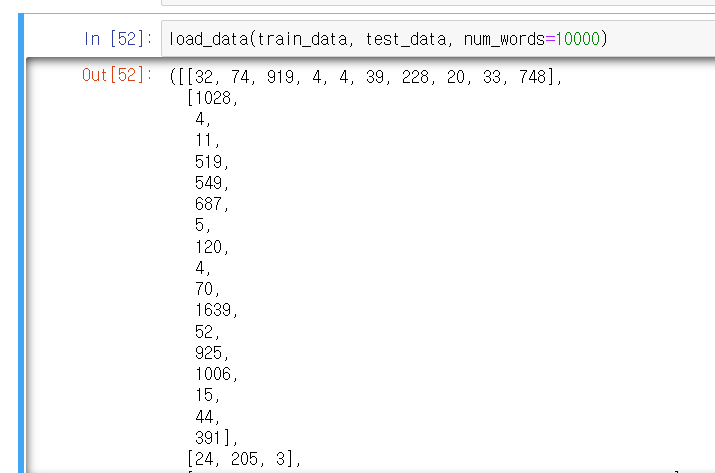

In [176]:
Image("[GD_5_Movie Review] images/11.PNG")

#### load_data를 출력해보면 위 이미지와 같이 나온다.

## Step 3-4. 시작, 종료 토큰 추가

In [5]:
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

## 이 부분을 해주어야 할 것 같다. imdb 노드 참고함

### <span style = "color:red;">word_to_index = {k:(v+3) for k,v in word_to_index.items()}를 적용했으나..</span>
뒤에 key error가 나 수정하였다.

In [38]:
word_to_index[0]

KeyError: 0

In [39]:
word_to_index[1]

KeyError: 1

In [40]:
word_to_index[2]

KeyError: 2

In [41]:
word_to_index[3]

KeyError: 3

In [42]:
word_to_index[4]

KeyError: 4

In [43]:
word_to_index[5]

KeyError: 5

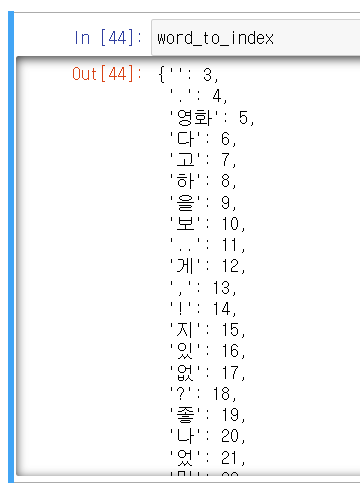

In [177]:
Image("[GD_5_Movie Review] images/12.PNG")

### <span style = "color:red;"> v+3을 하지 않고, word_to_index[] = 3도 만들지 않음, 이미 {'':3}으로 되어있기에</span>

In [132]:
word_to_index = {k:v for k,v in word_to_index.items()}

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  

In [55]:
word_to_index["<PAD>"]

0

In [58]:
word_to_index['영화']

5

## Step 3-5. index_to_word 딕셔너리 만들기

In [133]:
index_to_word = {index:word for word, index in word_to_index.items()}
#word_toindex를 만들어주었으니 index_to_word도 만들어주기

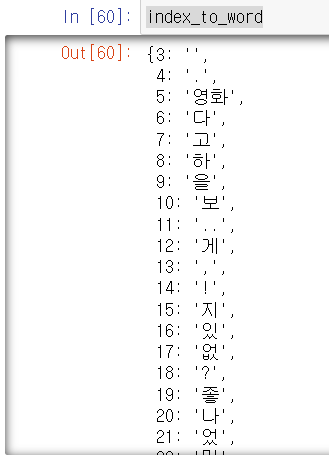

In [178]:
Image("[GD_5_Movie Review] images/13.PNG")

In [61]:
index_to_word[3]

''

In [62]:
index_to_word[1]

'<BOS>'

### <span style = "color:orange;">질문! index_to_word나 word_to_index에 시작 종료 토큰을 append 등으로 포함시키지 않아도 괜찮은가?</span>

## Step 3-6. 인코딩, 디코딩 함수 만들기

In [134]:
# 출처_노드
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 한다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [8]:
X_train[0] #예시로 하나만 출력해보자

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [63]:
get_encoded_sentence(X_train[0], word_to_index)

AttributeError: 'list' object has no attribute 'split'

#### <span style = "color:red;">이미 X_train[0]이 숫자로 바뀌어있는거라 encoded 함수는 필요없는건가? 그럼 decoded를 해봅시다.</span>

In [9]:
get_decoded_sentence(X_train[0], index_to_word)

'드라마 귀신 <UNK> <UNK> 같 씨 없 음 달'

### okay, 되었음!

In [10]:
get_decoded_sentence(X_train[10], index_to_word)

'<UNK> 같 인생  난다'

## Step 4. 모델 구성을 위한 데이터 분석 및 가공
1. 데이터셋 내 문장 길이 분포
2. 적절한 최대 문장 길이 지정
3. keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

## Step 4-1. 데이터셋 내 문장 길이 분포, 적절한 최대 문장 길이 지정

In [135]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)*100 / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


#### <span style = "color:red;">okay, 그럼 여기에서 적정 길이는 41이다!</span>

### <span style = "color:orange;">이 부분 시각화도 할 수 있지 않나?</span>

In [70]:
y_train

array([0, 1, 0, ..., 0, 1, 0])

## Step 4-2. keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

In [136]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [69]:
print(X_test.shape)

(49157, 41)


### <span style = "color:red;">패딩 완료!</span>

## Step 5. 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험

## Step 5-1.  검증용 데이터 분리
<span style = "color:red;">훈련용 데이터: 검증용 데이터 8:2의 비율로 나눔</span>    
전체 데이터 146182건의 20%에 해당하는 29236건은 검증용 데이터로 분리

In [137]:
# validation set 29236건 분리
X_val = X_train[:29236]   
y_val = y_train[:29236]

# validation set을 제외한 나머지 116946건
X_train = X_train[29236:]  
y_train = y_train[29236:]

print(X_train.shape)
print(y_train.shape)

(116946, 41)
(116946,)


In [72]:
X_train.shape

(146182, 41)

In [73]:
y_train.shape

(146182,)

In [76]:
X_val.shape

(29236, 41)

## Step 5-2. 3가지 모델 구성

###  model_1 (LSTM, word_to_index에서 인덱스 v+3으로 3개씩 미루고 만든 모델)

In [14]:
vocab_size = 10000    
word_vector_dim = 16 

model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(tf.keras.layers.LSTM(8))  
model_1.add(tf.keras.layers.Dense(8, activation='relu'))
model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


###  model_2 (1-D CNN, word_to_index에서 인덱스 v+3으로 3개씩 미루고 만든 모델)

In [15]:
vocab_size = 10000  
word_vector_dim = 16   

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.MaxPooling1D(5))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.GlobalMaxPooling1D())
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

###  model_3 (GlobalMaxPooling 적용, word_to_index에서 인덱스 v+3으로 3개씩 미루고 만든 모델)

In [16]:
vocab_size = 10000  
word_vector_dim = 16   

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


###  model_4 (LSTM, word_to_index에서 인덱스 v+3 미루지 않고 만든 모델)

In [67]:
vocab_size = 10000    
word_vector_dim = 16  

model_4 = tf.keras.Sequential()
model_4.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_4.add(tf.keras.layers.LSTM(8))  
model_4.add(tf.keras.layers.Dense(8, activation='relu'))
model_4.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


###  model_5 (1-D CNN, word_to_index에서 인덱스 v+3 미루지 않고 만든 모델)

In [68]:
vocab_size = 10000  
word_vector_dim = 16  

model_5 = tf.keras.Sequential()
model_5.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_5.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_5.add(tf.keras.layers.MaxPooling1D(5))
model_5.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_5.add(tf.keras.layers.GlobalMaxPooling1D())
model_5.add(tf.keras.layers.Dense(8, activation='relu'))
model_5.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

###  model_6 (GlobalMaxPooling 적용,word_to_index에서 인덱스 v+3 미루지 않고 만든 모델)

In [138]:
vocab_size = 10000 
word_vector_dim = 16   

model_6 = tf.keras.Sequential()
model_6.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_6.add(tf.keras.layers.GlobalMaxPooling1D())
model_6.add(tf.keras.layers.Dense(8, activation='relu'))
model_6.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model_6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## Step 6. 모델 훈련 개시

### model_1

In [17]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model_1.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 33s 8ms/step - loss: 0.6066 - accuracy: 0.6425 - val_loss: 0.4088 - val_accuracy: 0.8322
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3632 - accuracy: 0.8479 - val_loss: 0.3487 - val_accuracy: 0.8505
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3240 - accuracy: 0.8641 - val_loss: 0.3445 - val_accuracy: 0.8515
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3082 - accuracy: 0.8712 - val_loss: 0.3483 - val_accuracy: 0.8489
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2983 - accuracy: 0.8755 - val_loss: 0.3483 - val_accuracy: 0.8513
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2906 - accuracy: 0.8784 - val_loss: 0.3568 - val_accuracy: 0.8490
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2831 - accuracy: 0.8816 - val_loss: 0.3633 - val_accuracy: 0.8424
Epoch

## model_2

In [18]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model_2.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 20s 6ms/step - loss: 0.5160 - accuracy: 0.7261 - val_loss: 0.3619 - val_accuracy: 0.8421
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3350 - accuracy: 0.8575 - val_loss: 0.3440 - val_accuracy: 0.8511
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2997 - accuracy: 0.8746 - val_loss: 0.3432 - val_accuracy: 0.8504
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2727 - accuracy: 0.8877 - val_loss: 0.3482 - val_accuracy: 0.8508
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2443 - accuracy: 0.9028 - val_loss: 0.3634 - val_accuracy: 0.8492
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2141 - accuracy: 0.9175 - val_loss: 0.3802 - val_accuracy: 0.8477
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1836 - accuracy: 0.9320 - val_loss: 0.4127 - val_accuracy: 0.8444
Epoch

## model_3

In [19]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model_3.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 1s 4ms/step - loss: 0.5887 - accuracy: 0.7520 - val_loss: 0.4391 - val_accuracy: 0.8097
Epoch 2/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3866 - accuracy: 0.8329 - val_loss: 0.3661 - val_accuracy: 0.8362
Epoch 3/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3336 - accuracy: 0.8578 - val_loss: 0.3528 - val_accuracy: 0.8432
Epoch 4/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3047 - accuracy: 0.8722 - val_loss: 0.3510 - val_accuracy: 0.8456
Epoch 5/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2836 - accuracy: 0.8826 - val_loss: 0.3542 - val_accuracy: 0.8468
Epoch 6/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2666 - accuracy: 0.8911 - val_loss: 0.3595 - val_accuracy: 0.8459
Epoch 7/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2516 - accuracy: 0.8985 - val_loss: 0.3677 - val_accuracy: 0.8455
Epoch 

## model_4

In [70]:
model_4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model_4.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 7ms/step - loss: 0.6004 - accuracy: 0.6443 - val_loss: 0.4065 - val_accuracy: 0.8307
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3653 - accuracy: 0.8469 - val_loss: 0.3551 - val_accuracy: 0.8470
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3272 - accuracy: 0.8650 - val_loss: 0.3543 - val_accuracy: 0.8460
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3133 - accuracy: 0.8707 - val_loss: 0.3528 - val_accuracy: 0.8473
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3056 - accuracy: 0.8733 - val_loss: 0.3521 - val_accuracy: 0.8484
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2996 - accuracy: 0.8764 - val_loss: 0.3579 - val_accuracy: 0.8479
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2938 - accuracy: 0.8787 - val_loss: 0.3575 - val_accuracy: 0.8477
Epoch 

## model_5

In [71]:
model_5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model_5.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 2s 6ms/step - loss: 0.5293 - accuracy: 0.7199 - val_loss: 0.3627 - val_accuracy: 0.8434
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3388 - accuracy: 0.8562 - val_loss: 0.3443 - val_accuracy: 0.8514
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3052 - accuracy: 0.8729 - val_loss: 0.3416 - val_accuracy: 0.8533
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2802 - accuracy: 0.8854 - val_loss: 0.3450 - val_accuracy: 0.8523
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2546 - accuracy: 0.8973 - val_loss: 0.3535 - val_accuracy: 0.8513
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2256 - accuracy: 0.9118 - val_loss: 0.3701 - val_accuracy: 0.8488
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1953 - accuracy: 0.9262 - val_loss: 0.4048 - val_accuracy: 0.8448
Epoch 

## model_6

In [139]:
model_6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model_6.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 1s 4ms/step - loss: 0.6061 - accuracy: 0.7020 - val_loss: 0.4516 - val_accuracy: 0.8193
Epoch 2/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3865 - accuracy: 0.8372 - val_loss: 0.3641 - val_accuracy: 0.8385
Epoch 3/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3307 - accuracy: 0.8599 - val_loss: 0.3534 - val_accuracy: 0.8450
Epoch 4/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3028 - accuracy: 0.8740 - val_loss: 0.3529 - val_accuracy: 0.8458
Epoch 5/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2821 - accuracy: 0.8846 - val_loss: 0.3573 - val_accuracy: 0.8461
Epoch 6/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2656 - accuracy: 0.8918 - val_loss: 0.3641 - val_accuracy: 0.8456
Epoch 7/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2514 - accuracy: 0.8985 - val_loss: 0.3727 - val_accuracy: 0.8442
Epoch 

## Step 7. Loss, Accuracy 그래프 시각화

### model_1

In [20]:
results = model_1.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4735 - accuracy: 0.8348
[0.47348371148109436, 0.8348353505134583]


In [22]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


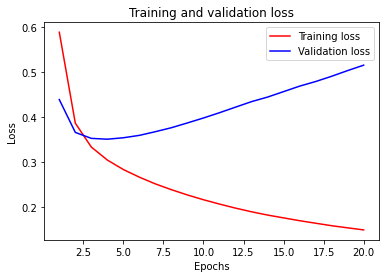

In [23]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

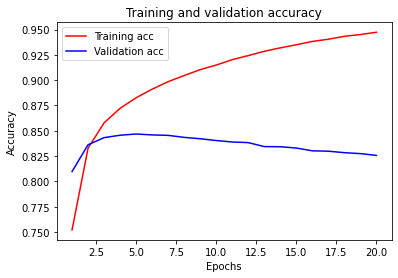

In [24]:
plt.clf()  

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### model_2

In [94]:
results = model_2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.0250 - accuracy: 0.8157
[1.024983286857605, 0.8156722187995911]


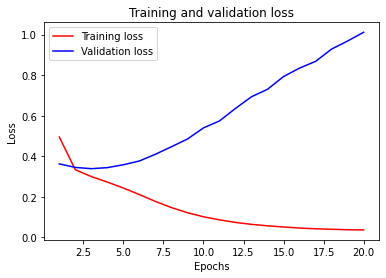

In [96]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

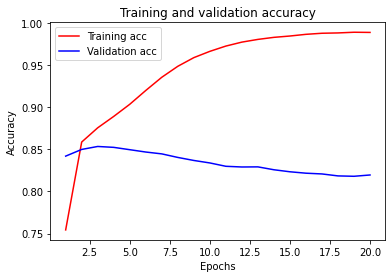

In [97]:
plt.clf()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### model_3

In [100]:
results = model_3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4993 - accuracy: 0.8259
[0.499346524477005, 0.8258640766143799]


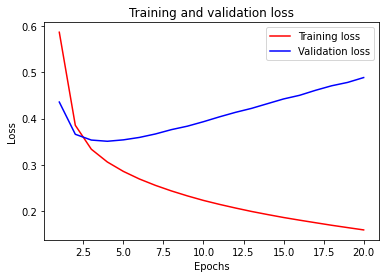

In [102]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

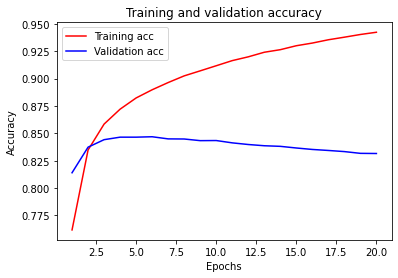

In [103]:
plt.clf()   

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### model_4

In [73]:
results = model_4.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4615 - accuracy: 0.8386
[0.46145302057266235, 0.8386191129684448]


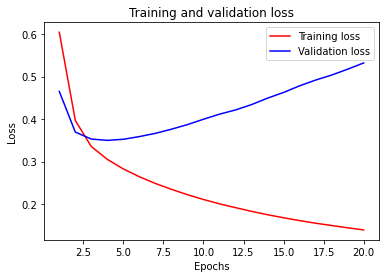

In [75]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

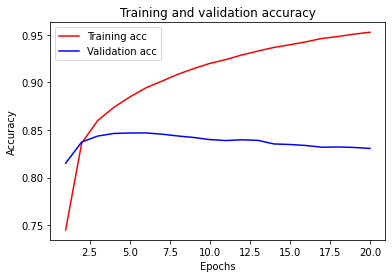

In [76]:
plt.clf() 

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### model_5

In [77]:
results = model_5.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.0574 - accuracy: 0.8165
[1.0573539733886719, 0.8164656162261963]


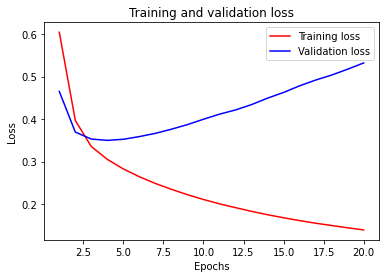

In [79]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

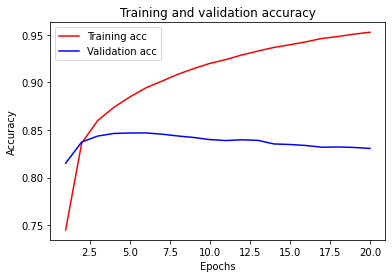

In [80]:
plt.clf()  

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### model_6

In [140]:
results = model_6.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5414 - accuracy: 0.8231
[0.5414087772369385, 0.8230770826339722]


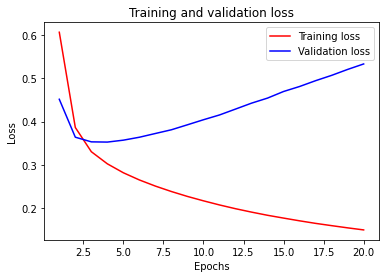

In [142]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

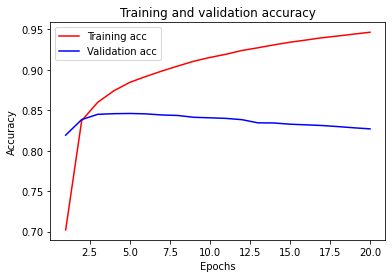

In [143]:
plt.clf()   

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### <span style = "color:red;">모델의 결과들을 보면 epoch 초기에(epoch=2, epoch=3) 훈련데이터 loss와 accuracy가 검증용 데이터와 위아래가 바뀌면서 과대적합이 일어나는 것 같다.</span>

## Step 8. 학습된 Embedding 레이어 분석

**학습된 임베딩 레이어를 분석한다는게 무슨 뜻일까?**

노드에서    
gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.     
gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함     

워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하는 방법 중에,     
단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법이 있다는 내용이 있었다.

In [26]:
embedding_layer_lstm = model_1.layers[0]
weights_lstm = embedding_layer_lstm.get_weights()[0]
print(weights_lstm.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [27]:
import os

word2vec_file_path_lstm = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model_1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

KeyError: 4

### <span style = "color:red;">왜 에러가 나지?</span>

처음에는 0부터 6까지 넣어보면서 6으로 넣으니 에러가 없어서 그렇게 했는데 이유는 정확히 알지 못했다.    
**ChatGPT의 도움을 받아 word_to_index와 index_to_word에서 시작과 종료 토큰을 정해준 부분을 수정함으로써 에러를 해결할 수 있었다.**

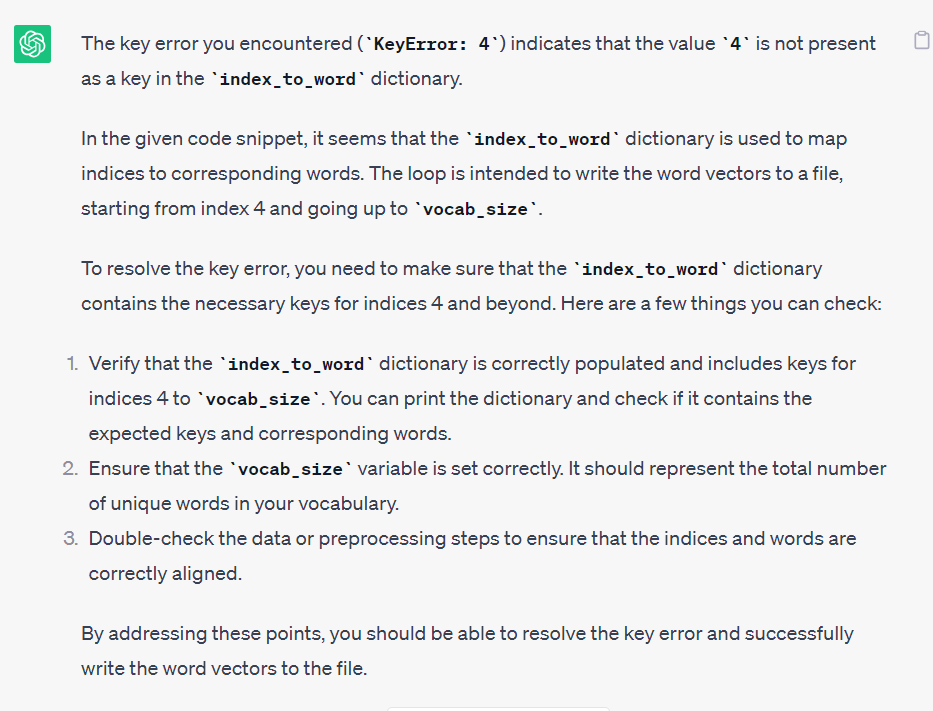

In [180]:
Image("[GD_5_Movie Review] images/14.PNG")

In [29]:
index_to_word[0]

'<PAD>'

In [28]:
index_to_word[1]

'<BOS>'

In [30]:
index_to_word[2]

'<UNK>'

In [31]:
index_to_word[3]

'<UNUSED>'

In [32]:
index_to_word[4]

KeyError: 4

In [33]:
index_to_word[5]

KeyError: 5

In [34]:
index_to_word[6]

''

In [35]:
index_to_word[7]

'.'

### <span style = "color:red;">word_to_index 수정 후</span>

### model_4

In [95]:
embedding_layer_lstm = model_4.layers[0]
weights_lstm = embedding_layer_lstm.get_weights()[0]
print(weights_lstm.shape)   

(10000, 16)


In [96]:
import os

word2vec_file_path_lstm = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

vectors = model_4.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

### 되었다!!!!!!

In [97]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [98]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)

In [99]:
vector = word_vectors['영화']
vector

array([-0.0221158 , -0.00847029,  0.02607079,  0.05799843,  0.04078989,
        0.02395756, -0.0276269 ,  0.02818974, -0.05197052,  0.00597016,
        0.00750844,  0.15466069,  0.02011649, -0.00039812, -0.06653924,
       -0.08342576], dtype=float32)

### 예에에에 에러가 안 났다!!!!!

In [101]:
word_vectors.similar_by_word("영화")

[('.', 0.8092817664146423),
 ('네요', 0.7537781000137329),
 ('음', 0.7478910088539124),
 ('차마', 0.718475341796875),
 ('됨', 0.6808542013168335),
 ('군요', 0.6806478500366211),
 ('같', 0.6667330265045166),
 ('란', 0.6529037952423096),
 ('성공', 0.6517946720123291),
 ('비디오', 0.6486023664474487)]

In [100]:
word_vectors.similar_by_word("사랑")

[('살아가', 0.9647619128227234),
 ('억압', 0.9514086246490479),
 ('남한', 0.9513139128684998),
 ('소름', 0.9480616450309753),
 ('치가', 0.9474541544914246),
 ('인상깊', 0.9469176530838013),
 ('놓칠', 0.9458088874816895),
 ('미소', 0.9435669183731079),
 ('완벽', 0.9430292248725891),
 ('갈증', 0.9425498843193054)]

### model_4의 학습된 embedding layer 분석
**영화**
: 성공, 비디오는 연관성이 있는 것 같으나 다른 단어들은 그렇지 않다.

**사랑**
: 살아가, 미소 등은 연관성이 있는 것 같으나 다른 단어들은 전체적으로 연관성이 낮은 것 같다.

### 이전에 나왔던 에러들..

In [152]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)
vector = word_vectors['컴퓨터']
vector

EOFError: unexpected end of input; is count incorrect or file otherwise damaged?

In [144]:
vector = word_vectors['영화']
vector

KeyError: "Key '영화' not present"

## model_5, model_6에 대해서도 학습된 embedding layer를 확인해보면

### model_5

In [102]:
embedding_layer_cnn = model_5.layers[0]
weights_cnn = embedding_layer_cnn.get_weights()[0]
print(weights_cnn.shape)   

(10000, 16)


In [103]:
word2vec_file_path_cnn = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model_5.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [104]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)

In [105]:
vector = word_vectors['영화']
vector

array([-0.04824757,  0.00982008,  0.02887318,  0.02322834,  0.10883081,
       -0.03505901, -0.02627912,  0.06614177,  0.01089459, -0.04505428,
        0.10491525, -0.0269903 , -0.01170951, -0.005523  , -0.00875792,
        0.0254078 ], dtype=float32)

In [106]:
word_vectors.similar_by_word("영화")

[('릭', 0.8151289820671082),
 ('여전', 0.8024603128433228),
 ('어떠', 0.7956936359405518),
 ('샤', 0.7933502793312073),
 ('초짜', 0.7893882989883423),
 ('비슷', 0.7879481911659241),
 ('바이', 0.7592917084693909),
 ('빨라서', 0.7582172155380249),
 ('숭', 0.7548112273216248),
 ('중학교', 0.7546499967575073)]

In [107]:
word_vectors.similar_by_word("사랑")

[('음미', 0.8406277894973755),
 ('마법사', 0.8168225884437561),
 ('서민', 0.8124799132347107),
 ('포근', 0.8124240040779114),
 ('픈', 0.8111517429351807),
 ('저격', 0.7864248752593994),
 ('절절', 0.784702718257904),
 ('후속', 0.7804763913154602),
 ('안다', 0.7795533537864685),
 ('에게서', 0.7669566869735718)]

### model_5의 학습된 embedding layer 분석
**영화**
: model_4보다 단어들이 연관성이 더 낮은 것 같다.     
(model_4) 성공, 비디오는 연관성이 있는 것 같으나 다른 단어들은 그렇지 않다.

**사랑**
: 음미, 포근, 절절, 후속 등은 model_4보다 연관성이 더 있어 보인다.    
(model_4) 살아가, 미소 등은 연관성이 있는 것 같으나 다른 단어들은 전체적으로 연관성이 낮은 것 같다.

### model_6

In [144]:
embedding_layer_gmp = model_6.layers[0]
weights_gmp = embedding_layer_gmp.get_weights()[0]
print(weights_gmp.shape)   

(10000, 16)


In [145]:
word2vec_file_path_gmp = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_gmp.txt'
f = open(word2vec_file_path_gmp, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model_6.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [146]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_gmp, binary=False)

In [147]:
vector = word_vectors['영화']
vector

array([-0.22273988, -0.25062507, -0.04955693, -0.11080166, -0.27963564,
       -0.1959387 ,  0.14005706, -0.30444294, -0.29110438, -0.16559713,
       -0.3102323 , -0.2320103 , -0.30220175, -0.29581133, -0.24690436,
       -0.1617096 ], dtype=float32)

In [148]:
word_vectors.similar_by_word("영화")

[('고', 0.9613101482391357),
 ('을', 0.9595510959625244),
 ('하', 0.9561267495155334),
 ('죵', 0.9540336728096008),
 ('다', 0.9537771344184875),
 ('스릴러', 0.9496399164199829),
 ('잡힌', 0.9482321739196777),
 ('아', 0.9475707411766052),
 ('같', 0.9459096193313599),
 ('보', 0.9456114172935486)]

In [149]:
word_vectors.similar_by_word("사랑")

[('역시', 0.9029635787010193),
 ('되게', 0.9020654559135437),
 ('통쾌', 0.8959953188896179),
 ('뮤', 0.8748064637184143),
 ('트', 0.8747791647911072),
 ('느와르', 0.8671143651008606),
 ('컬러', 0.8665996193885803),
 ('저희', 0.8654807806015015),
 ('괜찮', 0.8643437027931213),
 ('할아버지', 0.8636412620544434)]

### model_6의 학습된 embedding layer 분석
**영화**
: 스릴러, 잡힌 외에는 한 글자 단어들이 많이 보인다. 이 단어들은 연관성이 적어 보인다.     
(model_5) model_4보다 단어들이 연관성이 더 낮은 것 같다.     
(model_4) 성공, 비디오는 연관성이 있는 것 같으나 다른 단어들은 그렇지 않다.

**사랑**
: 이전 모델들보다 연관 단어들이 더 적은 것 같다.    
(model_5) 음미, 포근, 절절, 후속 등은 model_4보다 연관성이 더 있어 보인다.    
(model_4) 살아가, 미소 등은 연관성이 있는 것 같으나 다른 단어들은 전체적으로 연관성이 낮은 것 같다.

### <span style = "color:orange;"> 위 코드의 경우 출력할 때마다 출력 결과물이 차이가 난다.</span>
랜덤으로 훈련하기 때문에 그게 당연한 건가?

## Step 9. 한국어 Word2Vec 임베딩 활용하여 성능 개선
1. 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하기
2. 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러오기 
3. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용하기

#### 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors     
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)    
vector = word_vectors.wv[‘끝’]     

In [114]:
from gensim.models.keyedvectors import Word2VecKeyedVectors # 아까 위에서 가지고 왔던 것과 같은 코드

In [150]:
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

In [153]:
vector_1 = word2vec.similar_by_word('눈물')
vector_1

# word_vectors 변수에 담아주었는데 word2.vec라고 잘못 입력했기 때문에 에러

NameError: name 'word2vec' is not defined

In [151]:
vector = word_vectors.wv['영화']
vector

array([-1.8007389 , -1.1790098 , -2.4066596 ,  2.1384156 , -0.3537603 ,
        1.3749527 , -4.894612  , -3.6517198 ,  0.4411444 ,  0.78153926,
       -2.696888  , -1.7812852 , -2.1514654 , -4.813236  ,  2.7465918 ,
       -2.1620324 , -0.11467794, -1.2431171 ,  2.3979309 , -1.1060628 ,
       -0.41043055,  1.9500391 ,  0.7821002 ,  1.5899978 ,  1.6447444 ,
       -2.1265035 , -1.7981595 ,  1.7535795 ,  0.53717697, -1.212121  ,
       -4.466316  ,  4.5488324 ,  1.334441  , -0.9070271 ,  1.1931889 ,
        4.1563215 ,  1.9758307 , -0.9437562 , -0.2592725 ,  0.34935686,
        1.8562875 , -3.3249645 ,  1.1221625 ,  1.2836524 ,  3.9211376 ,
        3.8023994 ,  2.766269  ,  0.67293745,  2.2853644 , -5.1131716 ,
        0.32525915, -3.3079958 ,  5.3043513 , -3.8813758 , -0.32960036,
       -1.9527504 ,  3.8865075 , -3.5470378 , -0.21991685,  0.82119733,
       -0.9492492 ,  3.5472107 ,  1.322048  , -0.70640826,  0.52253807,
        1.4683235 , -1.1018689 ,  2.262941  , -0.7204685 , -1.76

In [118]:
vector_2 = word_vectors.similar_by_word.wv['영화']
vector_2

AttributeError: 'Word2Vec' object has no attribute 'similar_by_word'

In [158]:
# 시도 2
vector_3 = word_vectors.wv.similar_by_word['영화']
vector_3

TypeError: 'method' object is not subscriptable

### <span style = "color:red;">위 두 방법으로 할 때에는 에러가 났다.</span>

In [152]:
vocab_size = 10000    
word_vector_dim = 300  
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

In [153]:
embedding_matrix

array([[0.01104718, 0.98398528, 0.51718141, ..., 0.7105941 , 0.77898856,
        0.95186926],
       [0.20490422, 0.81980995, 0.09185697, ..., 0.29485131, 0.2819119 ,
        0.90452873],
       [0.15357947, 0.69375155, 0.46604615, ..., 0.31670598, 0.16508724,
        0.90052815],
       ...,
       [0.86900288, 0.79734719, 0.83243923, ..., 0.20916737, 0.85883268,
        0.85477679],
       [0.0104204 , 0.52614811, 0.7063364 , ..., 0.759394  , 0.92145354,
        0.66366994],
       [0.24104607, 0.07162319, 0.34202165, ..., 0.54263511, 0.87601748,
        0.05411073]])

In [154]:
embedding_matrix.shape

(10000, 300)

In [155]:
# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]

TypeError: argument of type 'Word2Vec' is not iterable

### <span style = "color:orange;">왜 코드에 Word2Vec이 없는데 이렇게 나오지?</span>

ChatGPT의 도움을 받아 알게된 것

**1. from gensim.models.keyedvectors import Word2VecKeyedVectors 에서 가지고 온**    
'Word2VecKeyedVectors'의 'word_vectors'객체가 for문 안에서 if index_to_word[i] in word_vectors: 이렇게 반복으로 사용되었는데     
그런데 'Word2VecKeyedVectors' 자체는 반복될 수 있는 객체가 아니라고 한다.


**2. 그래서 'word_vectors'의 각각의 word vectors에 접근하려면 대괄호 [ ]를 사용해서 접근할 수 있다고 한다.**    
(dictionary lookup 처럼.. 음.. 이건 또 뭐지요?)

**3. word = index_to_word[i]로 수정해 줌**      
**4. vocab은 처음에 attribute라고 설명해주었는데 이후 답변에서 property라고 함**     
**5. if word in word_vectors.wv.vocab:으로 wv를 붙여야 한다.**

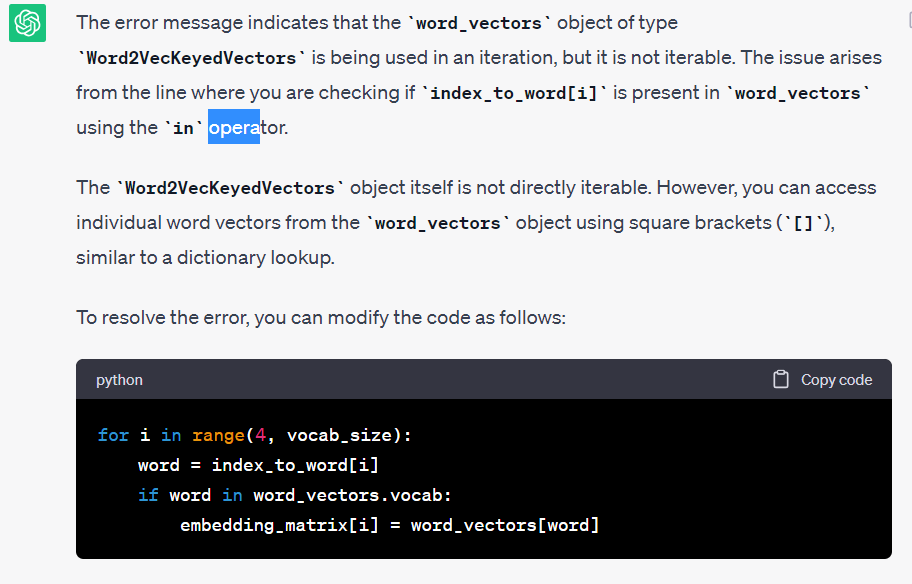

In [181]:
Image("[GD_5_Movie Review] images/15.PNG")

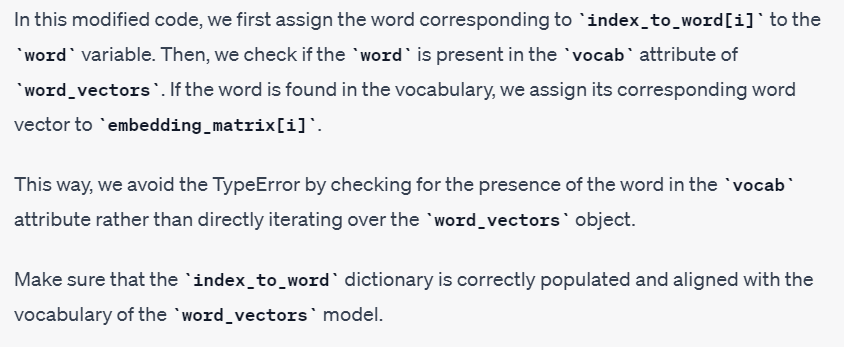

In [182]:
Image("[GD_5_Movie Review] images/16.PNG")

In [156]:
for i in range(4, vocab_size):
    word = index_to_word[i]
    if word in word_vectors.vocab:
        embedding_matrix[i] = word_vectors[word]

AttributeError: 'Word2Vec' object has no attribute 'vocab'

In [157]:
for i in range(4, vocab_size):
    word = index_to_word[i]
    if word in word_vectors.wv.vocab:
        embedding_matrix[i] = word_vectors[word]

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [159]:
for i in range(4, vocab_size):
    word = index_to_word[i]
    if word in word_vectors.key_to_index:
        embedding_matrix[i] = word_vectors.get_vector(word)

AttributeError: 'Word2Vec' object has no attribute 'key_to_index'

In [160]:
for i in range(4, vocab_size):
    word = index_to_word[i]
    if word in word_vectors.wv.key_to_index:
        embedding_matrix[i] = word_vectors.wv.get_vector(word)

ValueError: could not broadcast input array from shape (100,) into shape (300,)

### <span style = "color:red;">계속 에러나는 부분을 수정했는데, 이번에는 ValueError이다. 자세히 살펴보니...</span>

**1. 노드 5-10에서 구글의 Word2Vec을 불러오고 나서 300dim의 벡터로 이루어진 300만 개의 단어라고 했다.**          
구글 Word2Vec을 적용할 때 vocab_size = 10000, word_vector_dim = 300으로 적용     
(imdb 실습할 때 모델을 쌓을 때에 vocab_size=10000, word_vector_dim = 16이라고 했는데.. 바로 16 -> 300을 적용해도 되나? 궁금증..)      
**2. ValueError: could not broadcast input array from shape (100,) into shape (300,)**    
위 코드 에러에서 input의 shape이 달라 생긴 오류 같아서 word_vector_dim을 100으로 수정함     
((100,)에서 (300,)으로 broadcast하기 어렵다고 하니 현재 기존 input의 shape이 (100,)으로 파악     

In [161]:
vocab_size = 10000  
word_vector_dim = 100 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim) 

In [162]:
embedding_matrix

array([[0.17094946, 0.4387687 , 0.09403645, ..., 0.24287628, 0.91582136,
        0.67886625],
       [0.62423695, 0.65035439, 0.95497962, ..., 0.86028833, 0.1494599 ,
        0.61895829],
       [0.7459667 , 0.43639169, 0.71381608, ..., 0.06984476, 0.40865093,
        0.36409727],
       ...,
       [0.52454291, 0.23435251, 0.0496814 , ..., 0.57758701, 0.09624299,
        0.82925631],
       [0.45156374, 0.83162076, 0.25765691, ..., 0.80336338, 0.43497178,
        0.66149714],
       [0.06744191, 0.90298427, 0.68624355, ..., 0.76978695, 0.51643054,
        0.3890584 ]])

In [163]:
embedding_matrix.shape

(10000, 100)

In [164]:
for i in range(4, vocab_size):
    word = index_to_word[i]
    if word in word_vectors.wv.key_to_index:
        embedding_matrix[i] = word_vectors.wv.get_vector(word)

### 오오오오오옹 되었다!!!!!!!!!

## Step 9-1. 학습된 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습

In [165]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000   
word_vector_dim = 100  

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))   
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [168]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
229/229 [==============================] - 3s 7ms/step - loss: 0.5953 - accuracy: 0.6712 - val_loss: 0.5104 - val_accuracy: 0.7553
Epoch 2/10
229/229 [==============================] - 1s 5ms/step - loss: 0.4657 - accuracy: 0.7831 - val_loss: 0.4370 - val_accuracy: 0.7976
Epoch 3/10
229/229 [==============================] - 1s 5ms/step - loss: 0.4020 - accuracy: 0.8205 - val_loss: 0.4002 - val_accuracy: 0.8209
Epoch 4/10
229/229 [==============================] - 1s 5ms/step - loss: 0.3603 - accuracy: 0.8434 - val_loss: 0.3759 - val_accuracy: 0.8306
Epoch 5/10
229/229 [==============================] - 1s 5ms/step - loss: 0.3344 - accuracy: 0.8569 - val_loss: 0.3693 - val_accuracy: 0.8358
Epoch 6/10
229/229 [==============================] - 1s 5ms/step - loss: 0.3120 - accuracy: 0.8686 - val_loss: 0.3572 - val_accuracy: 0.8411
Epoch 7/10
229/229 [==============================] - 1s 5ms/step - loss: 0.2950 - accuracy: 0.8774 - val_loss: 0.3599 - val_accuracy: 0.8429
Epoch 

### <span style = "color:red;">Callbacks과 Earlystopping을 적용해 봄</span>

In [169]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-review-model.h5',
                                               save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                 restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                   callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
229/229 [==============================] - 2s 6ms/step - loss: 0.2453 - accuracy: 0.9007 - val_loss: 0.3864 - val_accuracy: 0.8394
Epoch 2/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2349 - accuracy: 0.9065 - val_loss: 0.3826 - val_accuracy: 0.8442
Epoch 3/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2242 - accuracy: 0.9113 - val_loss: 0.3944 - val_accuracy: 0.8433
Epoch 4/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2149 - accuracy: 0.9158 - val_loss: 0.4072 - val_accuracy: 0.8446
Epoch 5/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2077 - accuracy: 0.9189 - val_loss: 0.4167 - val_accuracy: 0.8418


## Step 9-2. 모델 평가

In [170]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3923 - accuracy: 0.8417
[0.39225250482559204, 0.841731607913971]


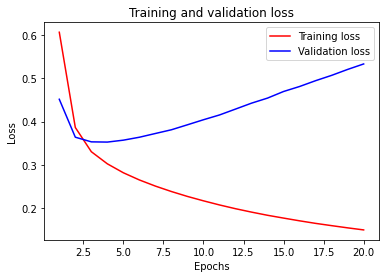

In [171]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

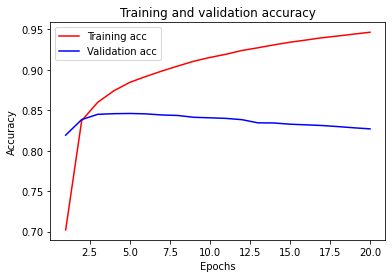

In [172]:
plt.clf()   

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Step 9-3. 추가로 customized한 model_7 적용 

In [187]:
vocab_size = 10000    
word_vector_dim = 32  

model_7 = tf.keras.Sequential()
model_7.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_7.add(tf.keras.layers.LSTM(8))  
model_7.add(tf.keras.layers.Dense(16, activation='relu'))
model_7.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_7.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dense_18 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 321,473
Trainable params: 321,473
Non-trainable params: 0
_________________________________________________________________


In [188]:
model_7.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model_7.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 7ms/step - loss: 0.5452 - accuracy: 0.6958 - val_loss: 0.3738 - val_accuracy: 0.8422
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3441 - accuracy: 0.8558 - val_loss: 0.3529 - val_accuracy: 0.8455
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3153 - accuracy: 0.8678 - val_loss: 0.3430 - val_accuracy: 0.8534
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2982 - accuracy: 0.8754 - val_loss: 0.3438 - val_accuracy: 0.8510
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2818 - accuracy: 0.8816 - val_loss: 0.3456 - val_accuracy: 0.8533
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2677 - accuracy: 0.8878 - val_loss: 0.3577 - val_accuracy: 0.8504
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2542 - accuracy: 0.8929 - val_loss: 0.3548 - val_accuracy: 0.8536
Epoch 

In [189]:
results = model_7.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5682 - accuracy: 0.8342
[0.5681774020195007, 0.8341843485832214]


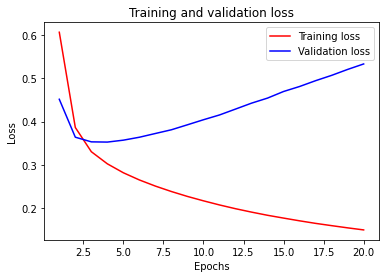

In [190]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

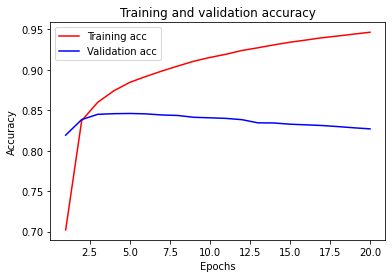

In [191]:
plt.clf() 

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [193]:
embedding_layer_lstm_7 = model_7.layers[0]
weights_lstm_7 = embedding_layer_lstm_7.get_weights()[0]
print(weights_lstm_7.shape)

(10000, 32)


In [194]:
word2vec_file_path_lstm_7 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_lstm_7.txt'
f = open(word2vec_file_path_lstm_7, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

vectors = model_7.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [195]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm_7, binary=False)

In [196]:
word_vectors.similar_by_word("영화")

[('결말', 0.7244428992271423),
 ('준다', 0.7238934636116028),
 ('아요', 0.713249921798706),
 ('습니다', 0.7099290490150452),
 ('"', 0.7018312215805054),
 ('풀어냈', 0.6909225583076477),
 ('니다', 0.6887975931167603),
 ('개성', 0.6820451617240906),
 ('줌', 0.6795910596847534),
 ('처음', 0.6762902736663818)]

In [199]:
from gensim.models.keyedvectors import Word2VecKeyedVectors 

In [200]:
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

In [201]:
vocab_size = 10000  
word_vector_dim = 100 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim) 

In [202]:
for i in range(4, vocab_size):
    word = index_to_word[i]
    if word in word_vectors.wv.key_to_index:
        embedding_matrix[i] = word_vectors.wv.get_vector(word)

In [203]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000   
word_vector_dim = 100  

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))   
model.add(tf.keras.layers.Conv1D(32, 5, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(32, 5, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 37, 32)            16032     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 3, 32)             5152      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

In [204]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-review-model.h5',
                                               save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                 restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                   callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
229/229 [==============================] - 3s 7ms/step - loss: 0.5976 - accuracy: 0.6700 - val_loss: 0.5038 - val_accuracy: 0.7587
Epoch 2/50
229/229 [==============================] - 1s 6ms/step - loss: 0.4585 - accuracy: 0.7871 - val_loss: 0.4313 - val_accuracy: 0.8030
Epoch 3/50
229/229 [==============================] - 1s 5ms/step - loss: 0.3926 - accuracy: 0.8253 - val_loss: 0.3986 - val_accuracy: 0.8210
Epoch 4/50
229/229 [==============================] - 1s 6ms/step - loss: 0.3503 - accuracy: 0.8470 - val_loss: 0.3738 - val_accuracy: 0.8350
Epoch 5/50
229/229 [==============================] - 1s 5ms/step - loss: 0.3209 - accuracy: 0.8633 - val_loss: 0.3606 - val_accuracy: 0.8406
Epoch 6/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2981 - accuracy: 0.8753 - val_loss: 0.3598 - val_accuracy: 0.8417
Epoch 7/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2798 - accuracy: 0.8838 - val_loss: 0.3613 - val_accuracy: 0.8433
Epoch 

In [205]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3698 - accuracy: 0.8393
[0.3698372542858124, 0.8393311500549316]


# 2. 결론(한국어 Word2Vec 적용 전과 후 모델 성능 비교)

**model_4**     
1537/1537 - 3s - loss: 0.4615 - accuracy: 0.8386     
[0.46145302057266235, 0.8386191129684448]     

**model_5**      
1537/1537 - 3s - loss: 1.0574 - accuracy: 0.8165       
[1.0573539733886719, 0.8164656162261963]       

**model_6**       
1537/1537 - 2s - loss: 0.5414 - accuracy: 0.8231     
[0.5414087772369385, 0.8230770826339722]

**model_한국어 Word2Vec 적용, 1-D CNN, Maxpooling, GlobalMaxpooling 적용**     
1537/1537 - 3s - loss: 0.3923 - accuracy: 0.8417     
[0.39225250482559204, 0.841731607913971]

**model_7_LSTM으로 학습한 model 4에 한국어 Word2Vec 적용, 1-D CNN(filters, kernel_size 수정),     
Maxpooling, GlobalMaxpooling, Dense layer(units 수정) 적용**       
1537/1537 - 3s - loss: 0.3698 - accuracy: 0.8393    
[0.3698372542858124, 0.8393311500549316]

노드에서 쌓은 모델의 구조와 동일하게 사용하였다.    
추가로 모델의 하이퍼파라미터나 구조를 수정해보아도 좋을 것 같다.     


### tf.keras.layers.Embedding의 embedding layer를 적용할 때보다
한국어 Word2Vec 임베딩을 활용하니 1-D CNN, Maxpooling, GlobalMaxpooling인 경우에서     
model_4와 비교하여    
<span style = "color:red;">loss는 0.4615 -> 0.3923 (15% 감소)    
acuuracy는 0.8386 -> 0.8417 (0.33% 향상)</span> 되었다.

# 3. 루브릭 관련 고려한 점

**1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.**     
3가지 이상의 모델이 성공적으로 시도됨     
(그렇다)     

**2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.**      
gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함    
(자체학습한 임베딩은 확인했는데, 사전학습 임베딩을 분석한 건 어떤 부분을 말하는 걸까...? 안 한 것 같은데..)

**3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.**     
네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함     
(그렇지 않다. 0.8417가 최고)     

# 4. 추가 공부

### 1. import gemsim에 대해서

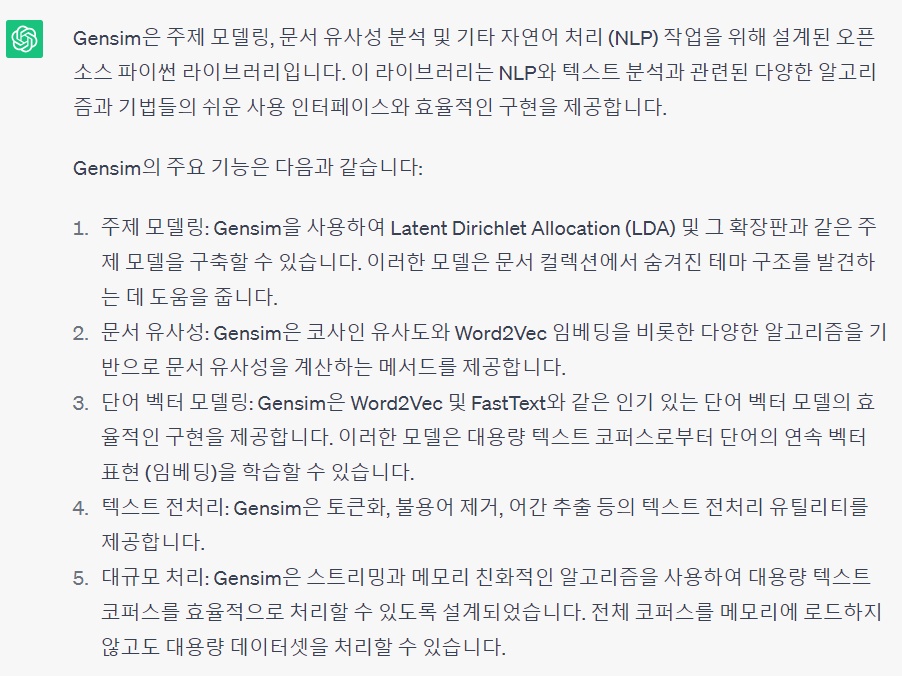

In [3]:
Image("[GD_5_Movie Review] images/06.PNG")

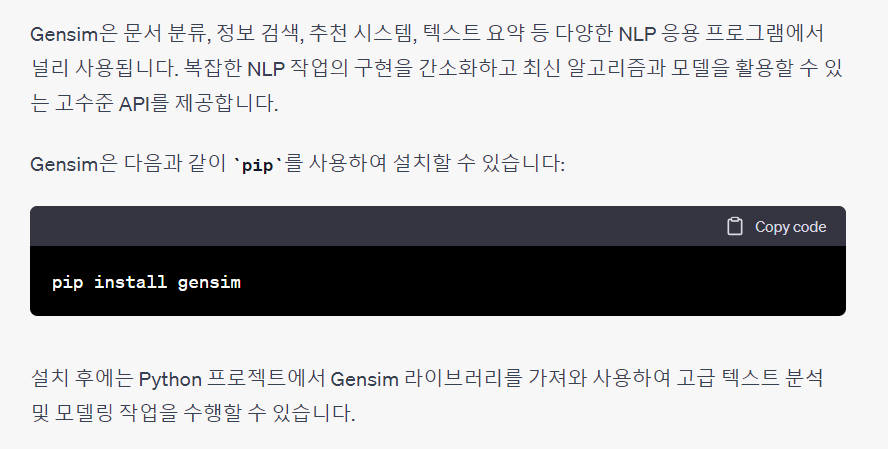

In [4]:
Image("[GD_5_Movie Review] images/07.PNG")

### 2. f-string 쓰는 방법 정리하기

print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(train_data), len(test_data)))

### 3. join()

join 함수는 매개변수로 들어온 리스트에 있는 요소 하나하나를 합쳐서 하나의 문자열로 바꾸어 반환하는 함수

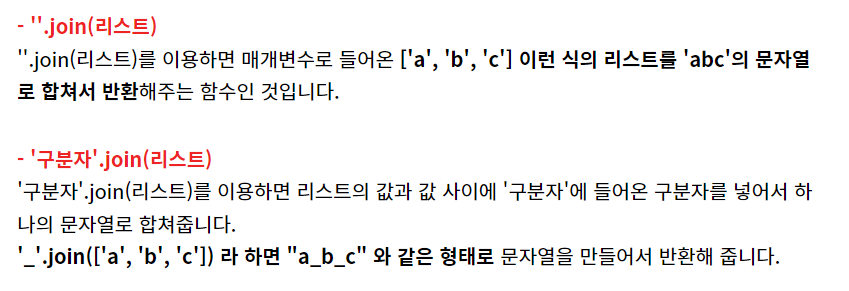

In [207]:
Image("[GD_5_Movie Review] images/05.PNG")

# https://blockdmask.tistory.com/468

# 5. 회고

### 1. 프로젝트에서 어려웠던 점, 해결을 위해 시도한 방법, 문제해결에 성공한 이유 또는 실패한 이유

- **프로젝트에서 어려웠던 점**  
    1. NLP 진행 과정이 이해가 되지 않는 부분이 많아 시간이 많이 걸렸다.   
    그래서 제출기한에 완성하여 제출하지 못했다. 추후 다른 NLP 노드들을 공부하면서 이해를 더 깊게 할 수 있었다.
    
    2. 정확도 85%를 달성하는 것
    수정한 모델로 적용해보았는데 아쉽게 0.84 부근의 accuracy를 보였다.
    
    3. 데이터로더를 만들 때의 예시코드를 이해하는 것, 한국어 Word2Vec를 적용하는 부분
    코드를 하나씩 살펴보느라 시간이 오래 걸렸다.

- **해결을 위해 시도한 방법**  
    1. 데이터로더를 만들 때의 예시코드의 경우 코드 하나씩 살펴보았다.
    2. 기술블로그와 ChatGPT의 도움을 받았다.
    

- **문제해결에 성공한 이유 또는 실패한 이유**  
    시간은 많이 걸렸지만, 코드를 많이 이해하게 되었고 내가 진행한 프로젝트라고 할 수 있을 만큼 공부한 흔적을 많이 담았다.

### 2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

- **프로젝트를 진행하면서 알아낸 점**  
1. 자연어 처리에 1-D CNN을 적용할 수 있는 것
2. 케라스 임베딩 레이어와 한국어 Word2Vec를 적용하는 과정

### <span style = "color:orange;">아직 모호한 점, 더 탐구해보고 싶은 부분(위 프로젝트 과정 중에서 발췌)</span>

**여전히 imdb.data_loader()는 찾을 수가 없는데.. 궁금하다 이게 따로 함수가 있나?**

imdb.data_loader()만 출력해보았을 때    
AttributeError: module 'keras.api._v2.keras.datasets.imdb' has no attribute 'data_loader'     
이런 에러가 난다.

**왜 inplace=True를 하면 위 사진처럼 나오지...?**

**토크나이저에서 그런데 왜 tag package를 사용하는 걸까?**     
tag는 품사를 알려주는거 아닌가?
품사 부착까지...

**for문 작성하는 방법**

**index_to_word나 word_to_index에 시작 종료 토큰을 append 등으로 포함시키지 않아도 괜찮은가?**

**텍스트데이터 길이 평균, 표준편차 분포 부분 시각화도 할 수 있지 않나?**

**ValueError**      
노드 5-10에서 구글의 Word2Vec을 불러오고 나서 300dim의 벡터로 이루어진 300만 개의 단어라고 했다.      
구글 Word2Vec을 적용할 때 vocab_size = 10000, word_vector_dim = 300으로 적용      
(imdb 실습할 때 모델을 쌓을 때에 vocab_size=10000, word_vector_dim = 16이라고 했는데.. 바로 16 -> 300을 적용해도 되나? 궁금증..)     

**rnn은 5-6 노드의 stateful / stateless에 관해 stateless하다는 거 아닌가?**      
아님 stateful?

**임베딩이란?**

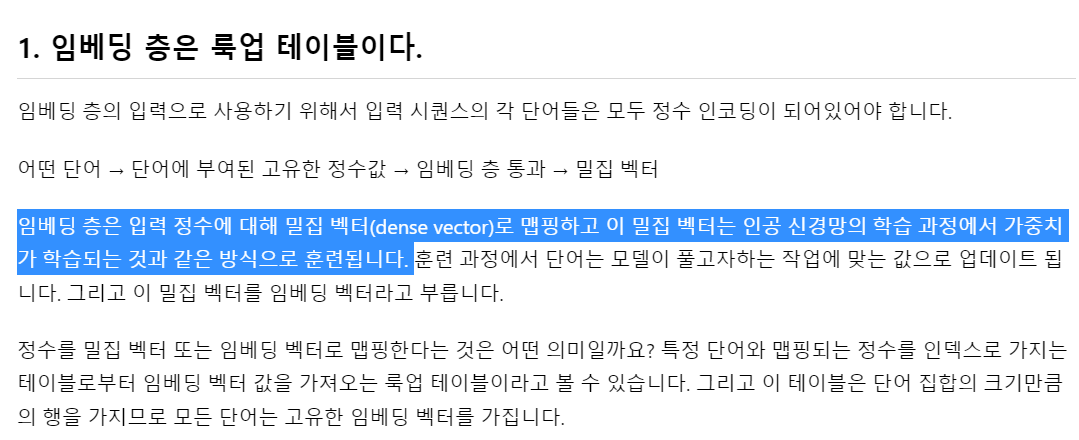

In [208]:
Image("[GD_5_Movie Review] images/09.PNG")

여기에서 가중치가 학습되는 것과 같은 방식으로 훈련된다는 건...... -> 역전파가 일어난다는 건가?


**룩업테이블이 생성되는 과정에 대해서 궁금하다.**

# 6. References

KoNLPy 공식 웹사이트, api 구조 시각화     
https://konlpy.org/ko/latest/index.html      

gensim 공식 웹사이트      
https://pypi.org/project/gensim/      

딕셔너리 items()        
https://devpouch.tistory.com/75       

딕셔너리에서 values 값 보기     
https://wikidocs.net/16#key-value       

.join()      
https://blockdmask.tistory.com/468      

Module: tf.keras.datasets.imdb      
https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb      

판다스 공식문서 중복데이터 제거      
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html     
https://wikidocs.net/154060      

결측치 제거 dropna     
https://rfriend.tistory.com/263          
https://wikidocs.net/153202       

토큰화란, 토크나이저란, 한국어 토크나이저       
https://wikidocs.net/21698       
https://ratsgo.github.io/nlpbook/docs/preprocess/tokenization/       

from collections import Counter      
https://www.daleseo.com/python-collections-counter/      

tolist()      
https://freedata.tistory.com/68       
https://cosmosproject.tistory.com/410       

counter.most_common()      
https://www.daleseo.com/python-collections-counter/       

enumerate()      
https://www.daleseo.com/python-enumerate/      

map()       
https://blockdmask.tistory.com/531